In [1]:
import mne
import os
import numpy as np

In [51]:
import pandas as pd

data_path = "data/emotiv/EP1.01.txt"

df_emotiv = pd.read_csv(data_path, sep='\t', header=None)



In [52]:
df_emotiv.columns = ['id', 'event', 'device', 'channel', 'code', 'size', 'data']
df_emotiv['data'] = df_emotiv['data'].apply(lambda x: list(map(float, x.split(','))))
df_emotiv.head()

,id,event,device,channel,code,size,data
0,67635,67635,EP,AF3,6,260,"[4395.384615, 4382.564102, 4377.435897, 4387.1..."
1,67636,67635,EP,F7,6,260,"[4489.230769, 4475.384615, 4474.358974, 4486.6..."
2,67637,67635,EP,F3,6,260,"[4538.461538, 4528.717948, 4524.615384, 4526.1..."
3,67638,67635,EP,FC5,6,260,"[4207.692307, 4205.641025, 4200.51282, 4194.35..."
4,67639,67635,EP,T7,6,260,"[4497.948717, 4498.461538, 4494.871794, 4497.9..."


In [53]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    # y = filtfilt(b, a, data)
    return y

In [54]:
# bandpass filter for each row's data column (which is a list of floats)
lowcut = 0.5
highcut = 30
fs = 128

df_emotiv_copy = df_emotiv.copy()


df_emotiv_copy['data'] = df_emotiv['data'].apply(lambda x: bandpass_filter(x, lowcut, highcut, fs))


In [55]:


min_size = 256

# drop rows that have size less than min_size
df_emotiv_copy = df_emotiv_copy[df_emotiv_copy['size'] >= min_size]

# then shorten all data columns to min_size
df_emotiv_copy['data'] = df_emotiv_copy['data'].apply(lambda x: x[:min_size])

In [56]:
df_emotiv_copy.shape

(904806, 7)

In [57]:
# print all length of data columns
df_emotiv_copy['data'].apply(len).unique()


array([256])

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import stft

def compute_stft_for_segment(segment, fs, n_fft=256, hop_length=128):
    """
    Compute STFT for a multi-channel EEG segment.
    Args:
        segment: 2D array of shape (256, 14), where rows are time points and columns are channels.
        fs: Sampling frequency in Hz.
        n_fft: Number of FFT points.
        hop_length: Number of overlapping samples between windows.
    Returns:
        stft_results: 3D array of shape (n_channels, n_freq_bins, n_time_frames)
                      containing the magnitude spectrograms for each channel.
    """
    stft_results = []

    # Compute STFT for each channel
    _, _, Zxx = stft(segment, fs, nperseg=n_fft, noverlap=hop_length)
    
    magnitude = np.abs(Zxx)
    
    magnitude_db = 20 * np.log10(magnitude + 1e-6)  # Add small value to avoid log(0)
    
    # normalize the spectrum
    magnitude_db -= magnitude_db.min()
    magnitude_db /= magnitude_db.max()
    
    colormap = plt.get_cmap('jet')
    spectogram_colored = colormap(magnitude_db)
    
    spectogram_uint8 = (spectogram_colored[:, :, :3] * 255).astype(np.uint8)

    
    return np.array(spectogram_uint8)  # Shape: (n_channels, n_freq_bins, n_time_frames)

In [59]:
df_emotiv_copy["data"]

0         [319.95956051800994, 1666.1927774765552, 3682....
1         [326.79103872077593, 1701.7130372662098, 3761....
2         [330.3747649684057, 1720.6844263083037, 3803.7...
3         [306.296604112478, 1595.786876110437, 3529.054...
4         [327.4256568611725, 1706.064922511325, 3773.66...
                                ...                        
910471    [329.62815534864836, 1717.354228389748, 3798.2...
910472    [307.97647579332926, 1604.502394987476, 3549.2...
910473    [333.1372206343024, 1735.7872799909135, 3839.9...
910474    [287.4820413306202, 1497.754963935756, 3312.54...
910475    [285.72750868779315, 1488.575768579764, 3292.8...
Name: data, Length: 904806, dtype: object

In [60]:
# change data column to stft results
n_fft  = min_size // 2
hop_length = n_fft // 2

df_emotiv_copy['stft'] = df_emotiv_copy['data'].apply(lambda x: compute_stft_for_segment(np.array(x), fs, n_fft, hop_length))


In [61]:
df_emotiv_copy['stft'][0].shape

(65, 5, 3)

In [62]:
# normalize stft results by max - min
# df_emotiv_copy['stft'] = df_emotiv_copy['stft'].apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))

In [63]:
# flatten stft results
# df_emotiv_copy['stft_flattened'] = df_emotiv_copy['stft'].apply(lambda x: x.flatten())
# df_emotiv_copy['stft_flattened'][0].shape

In [64]:
# need to create channel columns
# get number of channels
df_emotiv_copy["channel"].unique()

array(['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8',
       'FC6', 'F4', 'F8', 'AF4'], dtype=object)

In [65]:
df_emotiv_copy.columns

Index(['id', 'event', 'device', 'channel', 'code', 'size', 'data', 'stft'], dtype='object')

In [66]:
# group by the id 
len(df_emotiv_copy["event"].unique())

64629

In [67]:
# we need to group by event 
df_emotiv_grouped = df_emotiv_copy.groupby("event")

channels = df_emotiv_copy["channel"].unique()
# after grouping them we need to concatenate the data based on channels

# create a new data frame with the same columns
df_final = pd.DataFrame(columns=df_emotiv_copy.columns)

print(df_final)

temp_df_final = {}

for col in df_emotiv_copy.columns:
    temp_df_final[col] = []

# Step 3: Build the new DataFrame row by row
for event, group in df_emotiv_grouped:
    # Initialize a new row
    sorted_data_by_channels = group["data"]
    
    # stft is (65, 5, 3)
    # now we have 14 in each group
    # we want to make merged stft be (65, 14 * 5, 3)
    merged_stft = np.concatenate(group["stft"].values, axis=1)
    new_row = {
        "id": group["id"].values[0],  # Use the first ID for the group
        "event": event,               # Use the current event
        "device": group["device"].values[0],  # Use the first device for the group
        "channel": "all",             # Consolidate channels
        "code": group["code"].values[0],  # Use the first code
        "size": group["size"].values[0],  # Use the first size
        "data": np.concatenate(group["data"].values),  # Concatenate data arrays
        "stft": merged_stft,  # Concatenate STFT arrays
        # "stft_flattened": np.concatenate(group["stft_flattened"].values),  # Flattened concatenation
    }
    # Append the new row to the final DataFrame
    df_final = pd.concat([df_final, pd.DataFrame([new_row])], ignore_index=True)

Empty DataFrame
Columns: [id, event, device, channel, code, size, data, stft]
Index: []


In [68]:
print(df_final["stft"][0].shape)
# print(df_final["stft_flattened"][0].shape)

# change code of -1 to 10
df_final["code"] = df_final["code"].apply(lambda x: 10 if x == -1 else x)

(65, 70, 3)


In [69]:
# check unique of shape in stft
df_final["stft"].apply(lambda x: x.shape).unique()

array([(65, 70, 3)], dtype=object)

In [70]:
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class EEGDataset(Dataset):
    def __init__(self, data, labels):
        """
        Args:
            data: A NumPy array of shape (num_samples, channels, height, width).
            labels: A NumPy array of shape (num_samples,) with classification labels.
        """
        self.data = torch.tensor(data, dtype=torch.float32)  # Convert data to tensor
        self.labels = torch.tensor(labels, dtype=torch.long)  # Convert labels to tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = self.data[idx]  # Shape: (channels, height, width)
        y = self.labels[idx]  # Shape: ()
        return x, y
    
X = np.array(df_final['stft'].tolist())
y = df_final['code'].values

X = X.transpose(0, 3, 1, 2)  # Change shape from (n_samples, height, width, channels) to (n_samples, channels, height, width)

print("X shape:", X.shape)
print("y shape:", y.shape)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


# Create PyTorch Datasets
train_dataset = EEGDataset(X_train, y_train)
val_dataset = EEGDataset(X_val, y_val)
test_dataset = EEGDataset(X_test, y_test)


X shape: (64629, 3, 65, 70)
y shape: (64629,)


In [71]:
X_train.shape

(45240, 3, 65, 70)

In [72]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



class ModifiedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedCNN, self).__init__()
        # Layer 1: Conv2D + ReLU
        self.conv1 = nn.Conv2d(3, 256, kernel_size=5, stride=1, padding=2)  # Adjust padding for spatial dimensions
        self.conv1_bn = nn.BatchNorm2d(256)
        
        # Layer 2: Conv2D + ReLU
        self.conv2 = nn.Conv2d(256, 256, kernel_size=5, stride=1, padding=2)  # Keep the same padding
        self.conv2_bn = nn.BatchNorm2d(256)
        
        # Layer 3: MaxPool
        self.pool1 = nn.MaxPool2d(kernel_size=8, stride=2)  # Pooling reduces spatial dimensions
        
        # Layer 4: Conv2D + ReLU
        self.conv3 = nn.Conv2d(256, 128, kernel_size=5, stride=1, padding=2)
        self.conv3_bn = nn.BatchNorm2d(128)
        
        # Layer 5: Conv2D + ReLU
        self.conv4 = nn.Conv2d(128, 64, kernel_size=5, stride=1, padding=2)
        self.conv4_bn = nn.BatchNorm2d(64)
        
        # Layer 6: Fully Connected (Dense)
        self.flatten_size = self._get_flattened_size()
        self.fc1 = nn.Linear(self.flatten_size, 4096)
        
        # Layer 7: Dropout
        self.dropout = nn.Dropout(0.1)
        
        # Layer 8: Fully Connected (Softmax for classification)
        self.fc2 = nn.Linear(4096, num_classes)
    
    def _get_flattened_size(self):
        # Dynamically compute the flattened size after the last Conv2D layer
        with torch.no_grad():
            x = torch.zeros(1, 3, 65, 70)  # Input shape
            x = F.relu(self.conv1_bn(self.conv1(x)))
            x = F.relu(self.conv2_bn(self.conv2(x)))
            x = self.pool1(x)
            x = F.relu(self.conv3_bn(self.conv3(x)))
            x = F.relu(self.conv4_bn(self.conv4(x)))
            flattened_size = x.numel()
        return flattened_size
    
    def forward(self, x):
        # Layer 1
        x = F.relu(self.conv1_bn(self.conv1(x)))
        # Layer 2
        x = F.relu(self.conv2_bn(self.conv2(x)))
        # Layer 3
        x = self.pool1(x)
        # Layer 4
        x = F.relu(self.conv3_bn(self.conv3(x)))
        # Layer 5
        x = F.relu(self.conv4_bn(self.conv4(x)))
        # Flatten
        x = x.view(x.size(0), -1)
        # Layer 6
        x = F.relu(self.fc1(x))
        # Layer 7
        x = self.dropout(x)
        # Layer 8
        x = self.fc2(x)
        return x


# Define model

num_classes = len(np.unique(y_train))  # Number of classes
model = ModifiedCNN(num_classes)

# Print the model architecture
print(model)

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))

if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
    device = mps_device
else:
    print ("MPS device not found.")

model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total_samples = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels).item()
        total_samples += inputs.size(0)

    epoch_loss = running_loss / total_samples
    epoch_acc = running_corrects / total_samples * 100
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

ModifiedCNN(
  (conv1): Conv2d(3, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv1_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(256, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=8, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(256, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv3_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=59392, out_features=4096, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=4096, out_features=11, bias=True)
)
tensor([1.], device='mps:0')


KeyboardInterrupt: 

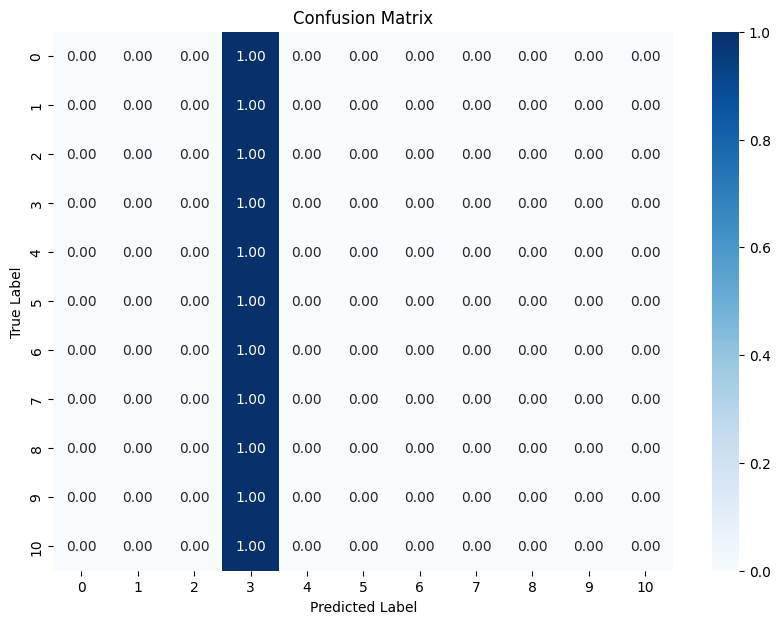

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# draw confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    cm = cm / cm.sum(axis=1)[:, np.newaxis]  # Normalize
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, cmap="Blues", fmt=".2f")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# Get predictions
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.tolist())
        y_pred.extend(predicted.tolist())

# Plot confusion matrix
plot_confusion_matrix(y_true, y_pred, range(11))